# AEMO DATA
##### Source : https://aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/aggregated-data

## Install Libraries


In [17]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'tensorflow', 'sklearn']

for package in packages:
    try:
        __import__(package)  
    except ImportError:
        install(package)  

from IPython.display import clear_output

clear_output(wait=True)

print("All required packages are installed.")


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/anup/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <B9202094-7D52-318C-99CF-7034B0E9F28D> /Users/anup/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


## Data Preparation

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '/Users/anup/Desktop/AEMO_DATA/Merged_PRICE_AND_DEMAND_VIC1.csv'
data = pd.read_csv(file_path)

data['SETTLEMENTDATE'] = pd.to_datetime(data['SETTLEMENTDATE'])

data.set_index('SETTLEMENTDATE', inplace=True)

data = data.fillna(method='ffill')

data = data[['TOTALDEMAND']]

train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]


/var/folders/9q/gks6hc0d4_n68vl0rvys8pgw0000gn/T/ipykernel_1624/41148242.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


## Time Series Forecasting Using Scikit-learn

#### Convert Time Series to Supervised Data

In this approach, we will shift the data to create lagged features that represent past time steps as input features to predict future demand.

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def create_lagged_features(data, lag=3):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df_lagged = pd.concat(columns, axis=1)
    df_lagged.columns = [f'lag_{i}' for i in range(lag, 0, -1)] + ['target']
    return df_lagged.dropna()


lag_steps = 3
data_lagged = create_lagged_features(data['TOTALDEMAND'], lag=lag_steps)

train_size = int(len(data_lagged) * 0.8)
train_lagged, test_lagged = data_lagged.iloc[:train_size], data_lagged.iloc[train_size:]

X_train, y_train = train_lagged.iloc[:, :-1], train_lagged.iloc[:, -1]
X_test, y_test = test_lagged.iloc[:, :-1], test_lagged.iloc[:, -1]


#### Train a Linear Regression Model

In [8]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred)
print(f'Linear Regression Model MSE: {mse_linear:.2f}')


Linear Regression Model MSE: 3576.52


#### Plot Predictions

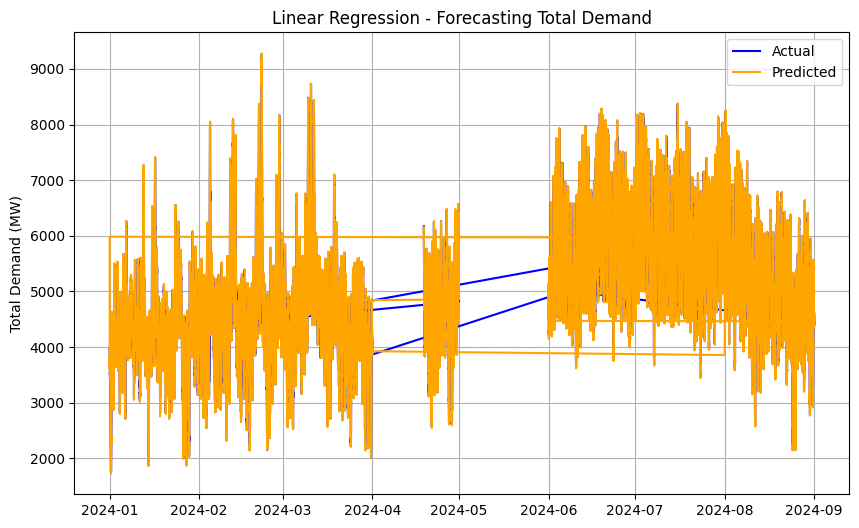

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='orange')
plt.title('Linear Regression - Forecasting Total Demand')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.grid(True)
plt.show()


#### Applying Gradient Boosting Models

Gradient Boosting Model MSE: 3125.22


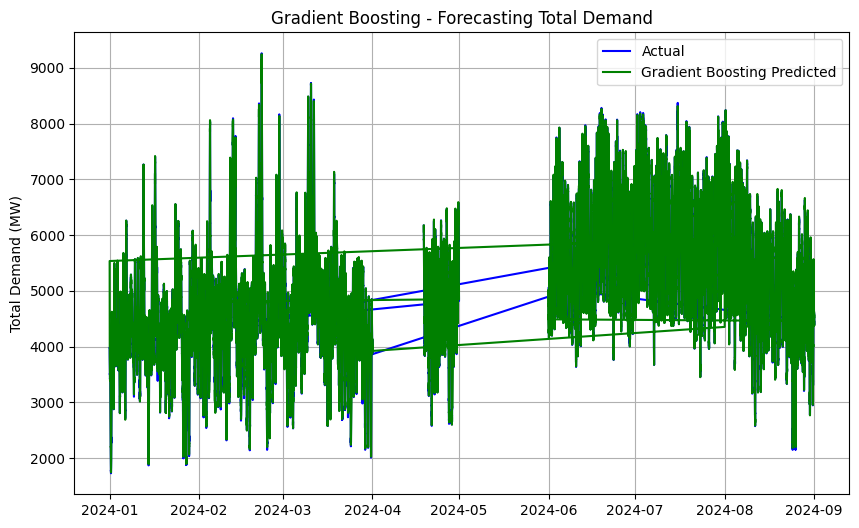

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(n_estimators=1000)
gbr_model.fit(X_train, y_train)

gbr_pred = gbr_model.predict(X_test)

mse_gbr = mean_squared_error(y_test, gbr_pred)
print(f'Gradient Boosting Model MSE: {mse_gbr:.2f}')

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
plt.plot(y_test.index, gbr_pred, label='Gradient Boosting Predicted', color='green')
plt.title('Gradient Boosting - Forecasting Total Demand')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.grid(True)
plt.show()


## Neural Networks - LSTM for Demand Forecasting

Epoch 1/20


/Users/anup/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3513/3513 ━━━━━━━━━━━━━━━━━━━━ 98s 27ms/step - loss: 0.0023
Epoch 2/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - loss: 6.4801e-05
Epoch 3/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 96s 27ms/step - loss: 5.9877e-05
Epoch 4/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 96s 27ms/step - loss: 5.7601e-05
Epoch 5/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 97s 27ms/step - loss: 5.7682e-05
Epoch 6/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 96s 27ms/step - loss: 5.5771e-05
Epoch 7/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 97s 28ms/step - loss: 5.4610e-05
Epoch 8/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 98s 28ms/step - loss: 5.5376e-05
Epoch 9/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 98s 28ms/step - loss: 5.3665e-05
Epoch 10/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 97s 28ms/step - loss: 5.2387e-05
Epoch 11/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 96s 27ms/step - loss: 5.3134e-05
Epoch 12/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 98s 28ms/step - loss: 5.1633e-05
Epoch 13/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 97s 27ms/step - loss: 5.2155e-05
Epoch 14/20
3513/3513 ━━━━━━━━━━━━━━

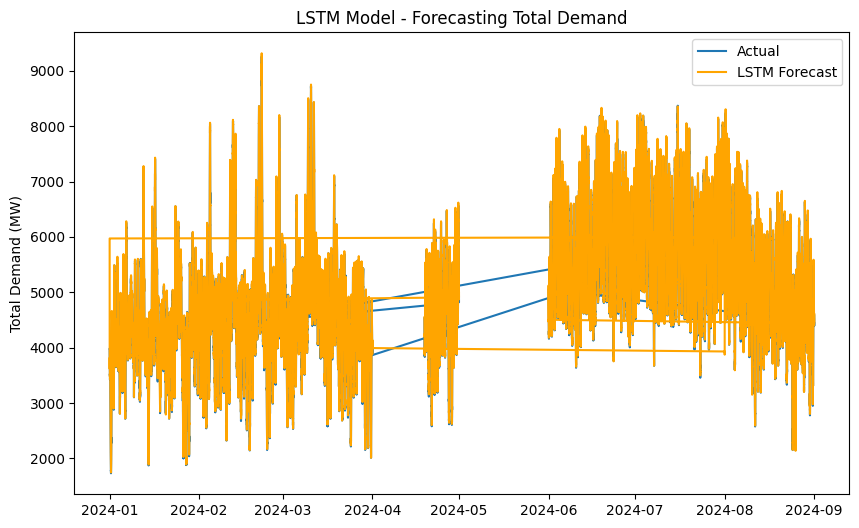

In [22]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

def create_dataset(X, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step - 1):
        Xs.append(X[i:(i + time_step), 0])
        ys.append(X[i + time_step, 0])
    return np.array(Xs), np.array(ys)

time_step = 60  
X_train, y_train = create_dataset(train_scaled, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))


lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X_train, y_train, batch_size=64, epochs=20)

test_scaled = scaler.transform(test)
X_test, y_test = create_dataset(test_scaled, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_pred = lstm_model.predict(X_test)

lstm_pred = scaler.inverse_transform(lstm_pred)

plt.figure(figsize=(10,6))
plt.plot(test.index[time_step+1:], test.values[time_step+1:], label='Actual')
plt.plot(test.index[time_step+1:], lstm_pred, label='LSTM Forecast', color='orange')
plt.title('LSTM Model - Forecasting Total Demand')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.show()


## Gradient Boosting Models (XGBoost)

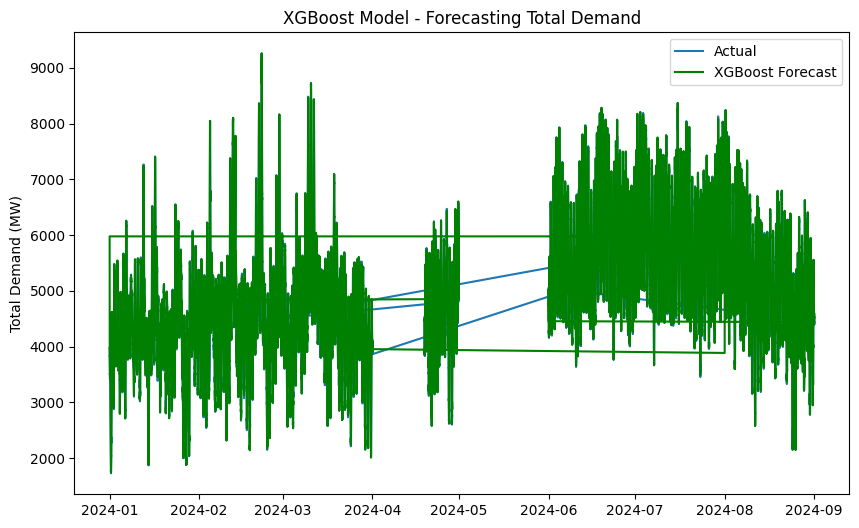

In [24]:
from xgboost import XGBRegressor

# Prepare data for XGBoost
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Fit the XGBoost model
xgb_model = XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)
xgb_pred = xgb_pred.reshape(-1, 1)

# Rescale predictions back to the original scale
xgb_pred = scaler.inverse_transform(xgb_pred)

# Plot actual vs XGBoost forecast
plt.figure(figsize=(10,6))
plt.plot(test.index[time_step+1:], test.values[time_step+1:], label='Actual')
plt.plot(test.index[time_step+1:], xgb_pred, label='XGBoost Forecast', color='green')
plt.title('XGBoost Model - Forecasting Total Demand')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.show()


## Model Evaluation

In [52]:
!pip install statsmodels

In [54]:
import statsmodels.api as sm

# Fit ARIMA model (adjust p, d, q as needed)
arima_model = sm.tsa.ARIMA(train, order=(5,1,0))  # Adjust (5,1,0) for your specific data
arima_fit = arima_model.fit()

# Generate predictions for the test set
arima_pred = arima_fit.forecast(steps=len(test))

# Calculate MSE for ARIMA model
mse_arima = mean_squared_error(test, arima_pred)
print(f'ARIMA Model MSE: {mse_arima:.2f}')


ModuleNotFoundError: No module named 'statsmodels'

In [47]:
from sklearn.metrics import mean_squared_error

mse_arima = mean_squared_error(test, arima_pred)
print(f'ARIMA Model MSE: {mse_arima:.2f}')

mse_lstm = mean_squared_error(test[time_step+1:], lstm_pred)
print(f'LSTM Model MSE: {mse_lstm:.2f}')

mse_xgb = mean_squared_error(test[time_step+1:], xgb_pred)
print(f'XGBoost Model MSE: {mse_xgb:.2f}')

mse_prophet = mean_squared_error(df_prophet['y'].iloc[train_size:], forecast['yhat'].iloc[train_size:])
print(f'Prophet Model MSE: {mse_prophet:.2f}')


NameError: name 'arima_pred' is not defined